In [1]:
import os
os.chdir("../../../../")

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from scripts.python.tsa.utsmodel import *
from scripts.python.tsa.ts_utils import *
from scripts.python.tsa.ts_eval import *
from sarimaxs import *

import warnings
warnings.filterwarnings('ignore')

## SARIMAX

,date,total,stringency_index,covid,solomon_islands_flights,solomon_islands_hotel,solomon_islands_travel
0,2009-01-01,1602,0.0,0.0,0.308297,0.000000,0.000000
1,2009-02-01,1422,0.0,0.0,0.261889,0.286989,0.323030
2,2009-03-01,1249,0.0,0.0,0.000000,0.146986,0.213515
3,2009-04-01,1499,0.0,0.0,0.388728,0.000000,0.282161
4,2009-05-01,1393,0.0,0.0,0.324701,0.104045,0.165545


training size : 144, testing size : 0
THE BENCHMARK EVALUATION FOR TOTAL 

STARTED TO CONDUCT STEPWISE SEARCHING FOR TOTAL 

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -170.836
Date:                              Wed, 02 Aug 2023   AIC                            361.672
Time:                                      16:15:05   BIC                            391.300
Sample:                                           0   HQIC                           373.711
                                              - 144                                         
Covariance Type:                                opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

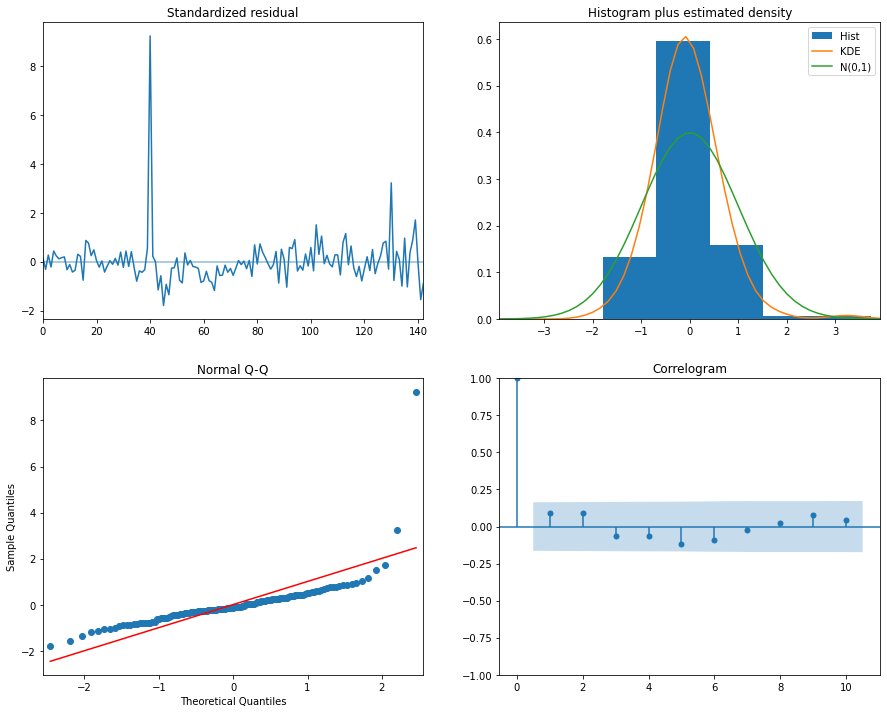

STARTED TO CONDUCT GRID SEARCHING FOR TOTAL 

STARTED TO CONDUCT CROSS-VALIDATION FOR TOTAL 

Best Models from Cross-validation is  ARIMA(2,0,2)(0,1,1)[12] intercept 



In [2]:
country = "solomon_islands"
sl_sl, best_mod, best_mod_pred = run_sarimax(
    country=country,
    y_vars=["total"],
    method="scaledlogit",
    exog_var=["covid", "stringency_index",
              str(country) + "_travel"])

In [3]:
calculate_evaluation(sl_sl["total"], sl_sl["total_pred"])

{'MSE': 81790.16495949097,
 'RMSE': 285.9897986982944,
 'MAE': 203.53870617427214,
 'SMAPE': 14.641816403435568}

## Ratio Approach

In [4]:
from scripts.python.tsa.mtsmodel import *


SOLOMON_ISLANDS's Official and Avaition Data.

 Create Loaded Factor for SOLOMON_ISLANDS:

 Regression SOLOMON_ISLANDS:
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     361.4
Date:                Wed, 02 Aug 2023   Prob (F-statistic):           2.13e-16
Time:                        16:27:15   Log-Likelihood:                 54.435
No. Observations:                  24   AIC:                            -92.87
Df Residuals:                      16   BIC:                            -83.45
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                             coef    std err          z      P>|z|      [0.025      0.975

,date,ratio,total,seats_arrivals_intl,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,pred_mean
0,2019-01-01,0.174372,1750,10036.0,0.215954,0.020090,0.176579,0.255330,0.144087,0.287822,2167.318755
1,2019-02-01,0.199662,1891,9471.0,0.200248,0.010644,0.179386,0.221110,0.136611,0.263886,1896.550863
2,2019-03-01,0.245332,2378,9693.0,0.211875,0.016112,0.180296,0.243453,0.143965,0.279784,2053.702452
3,2019-04-01,0.220940,2106,9532.0,0.242346,0.007781,0.227096,0.257596,0.180321,0.304371,2310.042163
4,2019-05-01,0.246881,2434,9859.0,0.241736,0.008231,0.225603,0.257869,0.179489,0.303984,2383.276493


,MSE,RMSE,MAE,SMAPE
mean,1.290167e+06,1135.855000,1065.215278,100.969388
naive,1.721267e+05,414.881597,268.478261,46.835106
ratio,4.628460e+04,215.138561,148.729331,23.922074


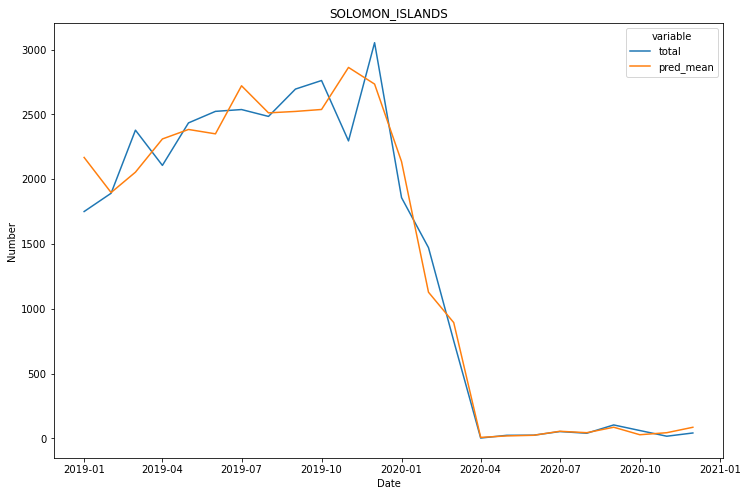

In [5]:
country = "solomon_islands"
mod = RatioPipe(country=country, data=None)
print(f"\n{country.upper()}'s Official and Avaition Data.")
mod.read_and_merge()

print(f"\n Create Loaded Factor for {country.upper()}:")
mod.transform()

print(f"\n Regression {country.upper()}:")
optimal_lag = int(4 * (len(mod.data)/100) ** (2/9)) + 1
mod.fit(formula="ratio~covid * stringency_index+C(quarter)+"+str(country)+"_travel",
        maxlags=optimal_lag)
pred_df = mod.get_prediction_df()

mean_pred, naive_pred = \
    mean_method(pred_df["total"]), naive_method(pred_df["total"])

benchmark = pd.DataFrame()
eval_name = ["mean", "naive", "ratio"]
for idx, pred in zip(eval_name, [mean_pred, naive_pred, pred_df["pred_mean"]]):
    eval_df = pd.DataFrame(calculate_evaluation(
        pred_df["total"], pred), index=[idx])
    benchmark = pd.concat([benchmark, eval_df])
display(benchmark)

ratio_viz_df = pred_df[["date", "total", "pred_mean"]].melt(id_vars="date")
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=ratio_viz_df, x="date", y="value", hue="variable")
ax.set(xlabel="Date", ylabel="Number", title=str(country).upper())
plt.show()

### Future Forecasting

In [6]:
gt = mod.read_trends_data()
gt.columns = [col.replace(" ", "_") for col in gt.columns]
solomon_si = mod.read_covid_data()

In [7]:
solomon_si_fu = (solomon_si[solomon_si.date >="2021-01-01"]
                 .dropna()
                 .reset_index().drop("index", axis=1))
temp_fu = (solomon_si_fu.merge(
    gt[["date", "solomon_islands_flights", "solomon_islands_travel"]],
    how="left", on="date"))
temp_fu["covid"] = (temp_fu.date >= "2020-03-12").astype(int)
temp_fu["quarter"] = temp_fu["date"].dt.quarter
temp_fu.columns = [col.replace(" ", "_") for col in temp_fu.columns]
temp_fu = temp_fu.dropna() 

In [8]:
upper = best_mod_pred.total.max() + 1
lower = best_mod_pred.total.min() - 1

In [9]:
uni_future = (best_mod.get_forecast(
    exog=temp_fu[["covid", "stringency_index", "solomon_islands_travel"]],
    steps=len(temp_fu))
    .summary_frame())
uni_future.columns.name = None
for col_idx, col in enumerate(uni_future.columns):
    for row_idx, _ in enumerate(uni_future[col]):
        uni_future.iloc[row_idx, col_idx] = inverse_scaledlogit(
            uni_future.iloc[row_idx, col_idx], upper, lower)

uni_future = (uni_future.reset_index()
              .drop("index", axis=1))
uni_future.columns = [col.replace("mean", "uni") for col in uni_future.columns]
uni_future["date"] = temp_fu["date"]
uni_future.head(5)

,uni,uni_se,uni_ci_lower,uni_ci_upper,date
0,23.410151,2143.587184,5.859177,102.293904,2021-01-01
1,31.755264,2159.385613,7.381173,144.929851,2021-02-01
2,39.860557,2159.441929,9.078332,181.151543,2021-03-01
3,34.958276,2170.356226,7.827360,164.253328,2021-04-01
4,42.845193,2170.849706,9.417961,200.504773,2021-05-01


In [10]:
future = mod.res.get_prediction(temp_fu).summary_frame()
future["date"] = temp_fu["date"]

In [11]:
aviation_path = os.getcwd() + "/data/tourism/aviation_seats_flights_pic.xlsx"
aviation = pd.read_excel(aviation_path)

sb_avi = (aviation[(aviation.ISO == "SB") & (aviation.Aircraft_type == "passenger")]
          .reset_index()
          .drop("index", axis=1)
          [["Date", "Seats_arrivals_intl", "Seats_arrivals_total"]])
sb_avi["Date"] = pd.to_datetime(sb_avi["Date"])
sb_avi["Month"], sb_avi["Year"] = sb_avi["Date"].dt.month, sb_avi["Date"].dt.year
sb_avi = sb_avi.groupby(["Year", "Month"]).sum().reset_index()
sb_avi["date"] = [str(y) + "-" + str(m)
                  for y, m in zip(sb_avi.Year, sb_avi.Month)]
sb_avi["date"] = pd.to_datetime(sb_avi["date"])
sb_avi_future = sb_avi[sb_avi.date >= "2021-01-01"].reset_index().drop("index", axis=1)
sb_avi_future.head(5)

,Year,Month,Seats_arrivals_intl,Seats_arrivals_total,date
0,2021,1,1408,1408,2021-01-01
1,2021,2,1640,1640,2021-02-01
2,2021,3,1632,1632,2021-03-01
3,2021,4,2164,2164,2021-04-01
4,2021,5,1292,1444,2021-05-01


In [12]:
future_colnames = [col for col in future.columns if col.startswith('mean')]
for col in future_colnames:
    if "se" in col:
        pass
    else:
        colname = col.replace("mean", "lf")
        future[colname] = sb_avi_future["Seats_arrivals_intl"] * future[col]
future.head(5)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,date,lf,lf_ci_lower,lf_ci_upper
0,-0.013569,0.014964,-0.042898,0.015761,-0.080462,0.053325,2021-01-01,-19.104827,-60.400931,22.191277
1,0.002009,0.027683,-0.052249,0.056267,-0.078975,0.082993,2021-02-01,3.294952,-85.688485,92.278390
2,-0.000864,0.024734,-0.049342,0.047614,-0.078095,0.076367,2021-03-01,-1.409980,-80.525554,77.705594
3,0.020117,0.013544,-0.006428,0.046663,-0.045603,0.085838,2021-04-01,43.533983,-13.910733,100.978700
4,0.032886,0.013765,0.005906,0.059866,-0.033011,0.098783,2021-05-01,42.488413,7.630531,77.346295


In [13]:
forecast = future.iloc[:, -4:]
forecast = forecast.merge(uni_future)
forecast.to_csv(os.getcwd() + "/data/tourism/solomon_islands/model/future.csv", encoding="utf-8")

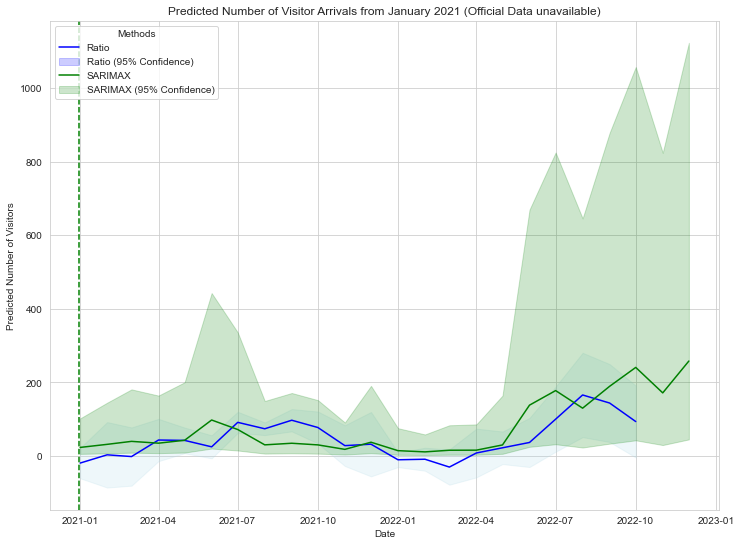

In [32]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.set_style("whitegrid")
sns.lineplot(data=forecast, x="date", y="lf", color="blue", )
sns.lineplot(data=forecast, x="date", y="uni",  color="green")
ax.fill_between(data=forecast, x="date", y1="lf_ci_lower",
                y2="lf_ci_upper", alpha=0.2, color="lightblue")
ax.fill_between(data=forecast, x="date", y1="uni_ci_lower",
                y2="uni_ci_upper", alpha=0.2, color="green")
plt.axvline(datetime(2020, 12, 31), linestyle="--", color="green")
plt.legend(title='Methods', loc='upper left', 
           labels=['Ratio', 'Ratio (95% Confidence)', 'SARIMAX', 'SARIMAX (95% Confidence)'])
plt.xlabel("Date")
plt.ylabel("Predicted Number of Visitors")
plt.title("Predicted Number of Visitor Arrivals from January 2021 (Official Data unavailable)")
plt.show()
fig.savefig(os.getcwd() + "/solomon_islands_prediction.png", dpi=400)